<a href="https://colab.research.google.com/github/sanmeshh/Synapse_LP/blob/week8/NLP_Task3_SANMESH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NLP Task 3**

## **DJS Synapse Learning Period**
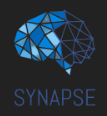

Hello Everyone. Hope you learn and have fun throughout the task!

Now, that we have understood how RNN works, let's dive deeper into LSTM and implement it from scratch.

Refer to the material linked below to understand LSTM in detail.

https://weberna.github.io/blog/2017/11/15/LSTM-Vanishing-Gradients.html

https://medium.com/@chunduri11/understanding-lstm-plain-and-simple-96026b4468c6

https://www.youtube.com/watch?v=YCzL96nL7j0&t=1009s&pp=ygUObHN0bSBzdGF0cXVlc3Q%3D

https://medium.com/analytics-vidhya/introduction-to-long-short-term-memory-lstm-a8052cd0d4cd

https://medium.com/@anishnama20/understanding-lstm-architecture-pros-and-cons-and-implementation-3e0cca194094

Load and preprocess the data.

In [ ]:
from tqdm import tqdm
import numpy as np

In [ ]:
##### Data #####
data = """To be, or not to be, that is the question: Whether \
'tis nobler in the mind to suffer The slings and arrows of ou\
trageous fortune, Or to take arms against a sea of troubles A\
nd by opposing end them. To die—to sleep, No more; and by a s\
leep to say we end The heart-ache and the thousand natural sh\
ocks That flesh is heir to: 'tis a consummation Devoutly to b\
e wish'd. To die, to sleep; To sleep, perchance to dream—ay, \
there's the rub: For in that sleep of death what dreams may c\
ome, When we have shuffled off this mortal coil, Must give us\
 pause—there's the respect That makes calamity of so long lif\
e. For who would bear the whips and scorns of time, Th'oppres\
sor's wrong, the proud man's contumely, The pangs of dispriz'\
d love, the law's delay, The insolence of office, and the spu\
rns That patient merit of th'unworthy takes, When he himself \
might his quietus make""".lower()

In [ ]:
chars = set(data)
data_size, char_size = len(data), len(chars)

In [ ]:
print(f'Data size: {data_size}, Char Size: {char_size}')

Data size: 866, Char Size: 32


In [ ]:
char_to_idx = {c:i for i, c in enumerate(chars)}
idx_to_char ={i:c for i,c in enumerate(chars)}

Perform train test split

In [ ]:
#perform train test split here
from sklearn.model_selection import  train_test_split
X_train,X_test,y_train,y_test=train_test_split(data[:-1],data[1:],test_size=0.2)


Define onHotEncoding Function


In [ ]:
##### Helper Functions #####
def oneHotEncode(text):
    output = np.zeros((char_size, 1))
    output[char_to_idx[text]] = 1

    return output

Read about Xavier Initialization.

https://cs230.stanford.edu/section/4/

In [ ]:
# Xavier Normalized Initialization
def initWeights(input_size, output_size):
    return np.random.uniform(-1, 1, (output_size, input_size)) * np.sqrt(6 / (input_size + output_size))

Define the Activation Functions required.

In [ ]:
def sigmoid(input, derivative = False):
    if derivative:
        return input * (1 - input)



    return 1 / (1 + np.exp(-input))

In [ ]:
#similarly define tanh activation function here.
def tanh(input,derivative=False):
    x=input
    if derivative:
      return 1-(x**2)


    z=(np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    return z

In [ ]:
def softmax(input):
    return np.exp(input) / np.sum(np.exp(input))

Now, let's implement LSTM from scratch!

In [ ]:
class LSTM:
    def __init__(self, input_size, hidden_size, output_size, num_epochs, learning_rate):
        # Hyperparameters
        self.learning_rate = learning_rate
        self.hidden_size = hidden_size
        self.num_epochs = num_epochs

        # Forget Gate
        self.wf = initWeights(input_size, hidden_size)
        self.bf = np.zeros((hidden_size, 1))

        # Input Gate
        self.wi = initWeights(input_size, hidden_size)
        self.bi = np.zeros((hidden_size, 1))

        # Candidate Gate
        self.wc = initWeights(input_size, hidden_size)
        self.bc = np.zeros((hidden_size, 1))

        # Output Gate
        self.wo = initWeights(input_size, hidden_size)
        self.bo = np.zeros((hidden_size, 1))

        # Final Gate
        self.wy = initWeights(hidden_size, output_size)
        self.by = np.zeros((output_size, 1))

    def reset(self):
        self.concat_inputs = {}

        self.hidden_states = {-1:np.zeros((self.hidden_size, 1))}
        self.cell_states = {-1:np.zeros((self.hidden_size, 1))}

        self.activation_outputs = {}
        self.cell_updates = {}
        self.output_gates = {}
        self.forget_gates = {}
        self.input_gates = {}
        self.outputs = {}

    def forward(self, inputs):
        self.reset()

        outputs = []
        for q in range(len(inputs)):
            self.concat_inputs[q] = np.concatenate((self.hidden_states[q - 1], inputs[q]))

            self.forget_gates[q] = sigmoid(np.dot(self.wf, self.concat_inputs[q]) + self.bf)
            self.input_gates[q] = sigmoid(np.dot(self.wi, self.concat_inputs[q]) + self.bi)
            self.cell_updates[q] = tanh(np.dot(self.wc, self.concat_inputs[q]) + self.bc)
            self.output_gates[q] = sigmoid(np.dot(self.wo, self.concat_inputs[q]) + self.bo)

            self.cell_states[q] = self.forget_gates[q] * self.cell_states[q - 1] + self.input_gates[q] * self.cell_updates[q]
            self.hidden_states[q] = self.output_gates[q] * tanh(self.cell_states[q])

            outputs += [np.dot(self.wy, self.hidden_states[q]) + self.by]

        return outputs

    def backward(self, errors, inputs):
        d_wf, d_bf = 0, 0
        d_wi, d_bi = 0, 0
        d_wc, d_bc = 0, 0
        d_wo, d_bo = 0, 0
        d_wy, d_by = 0, 0

        dh_next, dc_next = np.zeros_like(self.hidden_states[0]), np.zeros_like(self.cell_states[0])
        for q in reversed(range(len(inputs))):
            error = errors[q]

            # Final Gate Weights and Biases Errors
            d_wy += np.dot(error, self.hidden_states[q].T)
            d_by += error

            # Hidden State Error
            d_hs = np.dot(self.wy.T, error) + dh_next

            # Output Gate Weights and Biases Errors
            d_o = tanh(self.cell_states[q]) * d_hs * sigmoid(self.output_gates[q], derivative = True)
            d_wo += np.dot(d_o, inputs[q].T)
            d_bo += d_o

            # Cell State Error
            d_cs = tanh(tanh(self.cell_states[q]), derivative = True) * self.output_gates[q] * d_hs + dc_next

            # Forget Gate Weights and Biases Errors
            d_f = d_cs * self.cell_states[q - 1] * sigmoid(self.forget_gates[q], derivative = True)
            d_wf += np.dot(d_f, inputs[q].T)
            d_bf += d_f

            # Input Gate Weights and Biases Errors
            d_i = d_cs * self.cell_updates[q] * sigmoid(self.input_gates[q], derivative = True)
            d_wi += np.dot(d_i, inputs[q].T)
            d_bi += d_i

            # Candidate Gate Weights and Biases Errors
            d_c = d_cs * self.input_gates[q] * tanh(self.cell_updates[q], derivative = True)
            d_wc += np.dot(d_c, inputs[q].T)
            d_bc += d_c

            # Concatenated Input Error (Sum of Error at Each Gate!)
            d_z = np.dot(self.wf.T, d_f) + np.dot(self.wi.T, d_i) + np.dot(self.wc.T, d_c) + np.dot(self.wo.T, d_o)

            # Error of Hidden State and Cell State at Next Time Step
            dh_next = d_z[:self.hidden_size, :]
            dc_next = self.forget_gates[q] * d_cs

        for d_ in (d_wf, d_bf, d_wi, d_bi, d_wc, d_bc, d_wo, d_bo, d_wy, d_by):
            np.clip(d_, -1, 1, out = d_)

        self.wf += d_wf * self.learning_rate
        self.bf += d_bf * self.learning_rate

        self.wi += d_wi * self.learning_rate
        self.bi += d_bi * self.learning_rate

        self.wc += d_wc * self.learning_rate
        self.bc += d_bc * self.learning_rate

        self.wo += d_wo * self.learning_rate
        self.bo += d_bo * self.learning_rate

        self.wy += d_wy * self.learning_rate
        self.by += d_by * self.learning_rate

    def train(self, inputs, labels):
        inputs = [oneHotEncode(input) for input in inputs]

        for _ in tqdm(range(self.num_epochs)):
            predictions = self.forward(inputs)

            errors = []
            for q in range(len(predictions)):
                errors += [-softmax(predictions[q])]
                errors[-1][char_to_idx[labels[q]]] += 1

            self.backward(errors, self.concat_inputs)

    # Test
    def test(self, inputs, labels):
        accuracy = 0
        probabilities = self.forward([oneHotEncode(input) for input in inputs])

        output = ''
        for q in range(len(labels)):
            prediction = idx_to_char[np.random.choice([*range(char_size)], p = softmax(probabilities[q].reshape(-1)))]

            output += prediction

            if prediction == labels[q]:
                accuracy += 1

        print(f'Ground Truth:\nt{labels}\n')
        print(f'Predictions:\nt{"".join(output)}\n')

        print(f'Accuracy: {round(accuracy * 100 / len(inputs), 2)}%')



Hope you understood the implementation! Explain what you understood in detail.

Ans:Firstly the parameters  such as size of the input , size of the hidden state epochs ,etc are intialized. After these parameters,weights and biases for each gate such as forget gate , input gate , candidate gate ,final gate are initialized. The size of the weight matrix of all the gates except final gate
is  input size * hidden size whereas the size of the bias matrix is hidden size *1.For the final gate the weight matrix is of size hidden * output.

For each input , the hidden state vector and the actual input vector of the given character are concatenated and thereby given to the forget,input,candidate,output gates which help in calcualting the new cell state and the new hidden state vector.

In backward propagation , as usual the derivative of the loss function is calculated wrt to  the weights and biases of the output gate and then through the weights and biases of forget gate ,input gate , candidate gate and so on..

The model is then trained . The train function one hot encodes the input and uses forward pass to obtain the probability with the help of softmax , of each output.These probabilities help in calculating the errors and these errors are sent to the backpropagation function (backward).The test function then calculates the prediction for each input passed and if the prediction matches the label the accuracy variable is incremented by 1. Then the ratio of the accuracy variable and the length of the inputs is presented as the accuracy of the model.












In [ ]:
#error exactly define kaise?


# Initialize Network
hidden_size =25   #fill this

lstm = LSTM(input_size = char_size + hidden_size, hidden_size = hidden_size, output_size = char_size, num_epochs = 1_000, learning_rate = 0.05)

##### Training #####

lstm.train(X_train, y_train)

##### Testing #####

lstm.test(X_train,y_train)


100%|██████████| 1000/1000 [01:48<00:00,  9.22it/s]

Ground Truth:
t['e', 'h', 'l', 'y', 'c', 'e', 'o', 't', 'o', 's', 'r', ' ', ' ', ' ', 'i', 'n', 'w', ' ', ' ', 'i', 'h', 't', ' ', 's', ' ', 'a', 'l', 't', 'a', 's', 'l', ' ', 's', 't', 'v', 'e', 's', 'u', ' ', ' ', ' ', 'i', 'o', 'h', 'r', ' ', ' ', 'a', 'e', 'a', 'h', 'e', 'b', 'e', 'e', 'e', 's', ' ', 'o', 't', 'f', ' ', 'e', 'o', 'n', 'o', 'n', 'a', 'e', 's', ' ', 'i', 'n', 'p', 'e', 'u', 'h', ' ', 'l', 'o', "'", ' ', 'e', 'd', "'", 'e', 'y', 's', 'l', 'h', ' ', ' ', 'e', 'n', 'o', 'h', ' ', 'o', 't', 'd', 'o', 'r', ';', ' ', 'd', 's', 'h', 'o', 't', ' ', 'n', 't', ' ', 'c', 'i', 's', 'i', ' ', ' ', 'e', 'e', 'f', 'o', 'g', 'a', 'h', 'n', 'a', ' ', 'h', ' ', 't', ':', 'l', 'a', 'o', 'o', ' ', ' ', 'o', ' ', 'n', 'r', 's', ' ', '.', 'w', 'r', 'h', 'p', 'i', 'y', 'y', 'a', 'g', 'o', ' ', 's', 'h', 's', 'n', 'i', 'r', ',', 'd', 'o', 'i', ' ', 's', ' ', 'm', ' ', "'", 'h', 'm', 'a', 'e', 'e', 'n', 'o', 't', ' ', 'q', ',', 'd', "'", 'e', 'o', 'n', ';', 'a', 'm', 'c', 'i', 'u', 'w', ' ',

**Machine Translation using Encoder-Decoder**

Read about Encoder-Decoder in the links provided below

https://www.youtube.com/watch?v=KiL74WsgxoA&t=292s&pp=ygUcZW5jb2RlciBkZWNvZGVyIGFyY2hpdGVjdHVyZQ%3D%3D

https://www.youtube.com/watch?v=L8HKweZIOmg&pp=ygUcZW5jb2RlciBkZWNvZGVyIGFyY2hpdGVjdHVyZQ%3D%3D

https://medium.com/analytics-vidhya/machine-translation-encoder-decoder-model-7e4867377161

https://medium.com/@anishnama20/exploring-the-power-of-encoder-decoder-models-pros-cons-and-applications-8bfbe2e66e76

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import keras
import matplotlib.pyplot as plt
import numpy as np

Download the dataset provided with the task for this implementation.

In [ ]:
data_path = "/content/fra.txt"


In [ ]:
num_samples = 10000

In [ ]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t"+target_text+"\n" #using the above logic fill this line of code
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

    for char in target_text:
      if char not in target_characters:
        target_characters.add(char)
#     similarly write the code for target_text



In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))#fill this
num_encoder_tokens = len(input_characters)
num_decoder_tokens =len(target_characters)                #fill this
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])#fill this

In [ ]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59


In [ ]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char,i) for i, char in enumerate(target_characters)])

In [ ]:
#why here decoder is len of input texts and blah blah
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype="float32",
)
decoder_input_data =np.zeros((len(target_texts),max_decoder_seq_length,num_decoder_tokens),dtype="float32") #similarly fill this
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype="float32",
)

In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space

In [ ]:
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [ ]:
# We discard `encoder_outputs` and only keep the states.
encoder_states =[state_h,state_c] #fill this

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

In [ ]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense_layer = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense_layer(decoder_outputs)

 Define the model that will turn
 `encoder_input_data` & `decoder_input_data` into `decoder_target_data`

In [ ]:
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)   #run this line of code

In [ ]:
#train the model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    #implement appropriate optimizer, loss and accuracy

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
)
# Save model
model.save("model.keras")

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.7067 - loss: 1.8287 - val_accuracy: 0.7081 - val_loss: 1.0427
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.7512 - loss: 0.9068 - val_accuracy: 0.7615 - val_loss: 0.8845
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7926 - loss: 0.7697 - val_accuracy: 0.7897 - val_loss: 0.7573
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8188 - loss: 0.6508 - val_accuracy: 0.8066 - val_loss: 0.6699
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8335 - loss: 0.5816 - val_accuracy: 0.8223 - val_loss: 0.6182
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8455 - loss: 0.5348 - val_accuracy: 0.8272 - val_loss: 0.5904
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8531 - loss: 0.5076 - val_accuracy: 0.8349 - val_loss: 0.5674
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8580 - loss: 0.4849 - 

In [ ]:
model = keras.models.load_model("model.keras")

In [ ]:
encoder_inputs = model.input[0]
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [ ]:
decoder_inputs = model.input[1]
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec,state_c_dec]#fill this taking encoder as reference
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [ ]:
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

Run the cell below and explain here in detail how the cell works.



In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value, verbose=0
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence

In [ ]:
for seq_index in range(50):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: En route !

-
Input sentence: Go.
Decoded sentence: En route !

-
Input sentence: Go.
Decoded sentence: En route !

-
Input sentence: Go.
Decoded sentence: En route !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run!
Decoded sentence: Fuyons !

-
Input sentence: Run.
Decoded sentence: Fuyez !

-
Input sentence: Run.
Decoded sentence: Fuyez !

-
Input sentence: Run.
Decoded sentence: Fuyez !

-
Input sentence: Run.
Decoded sentence: Fuyez !

-
Input sentence: Run.
Decoded sentence: Fuyez !

-
Input sentence: Run.
Decoded sente

**Bonus Task**

Exploring Bidirectional RNNs and the BiLSTM Architecture

Implementing a BiLSTM model for a specific NLP task (e.g., named entity recognition or sentiment analysis)

# BiDirectional RNNS:

RNNs process data as a sequence of vectors(one-by-one) rather than feedforward neural networks, which process data as a fixed-length vector. Each vector is processed depending on the hidden state from the previous phase.

> BiRNNs:

As the name suggests these RNNs work in both the directions forward as well as backward direction,in order for the network to use information from both the past and future context in its predictions.This is the main difference between the usual RNNs and BiRNNs.For the both directions , there are two hidden layers , one works for the forward and the other for backward.

These hidden layers are nothing but a seq of vectors which are influenced by the past vectors.


> Working:



These hidden layers are nothing but a seq of vectors which are influenced by the past vectors.
The words in form of embeddings are inputted in each hidden layer.These embeddings.Both the forward and backward directions are used to process the data. On the basis of the input at that step and the hidden state at step t-1, the hidden state at time step t is determined in the forward direction. The input at step t and the hidden state at step t+1 are used to calculate the hidden state at step t in a reverse way.

A non-linear activation function(mostly tanh) on the weighted sum of the input and previous hidden state is used to calculate the hidden state at each step.
 And then for each concatenated input of the forward and the backward rnns,the outputs are also concatenated and represented as a single output for that layer.



> Ht(Forward) = tanh(Xt * Wxh (forward) + Ht-1 (Forward) * Whh (Forward) + bH(Forward))

> Ht (Backward) = tanh(Xt * Wxh (Backward) + Ht+1 (Backward) * Whh(Backward) + bH (Backward))

>Y=sigmoid(Ht * Wy + by)



# BiLSTM Archi

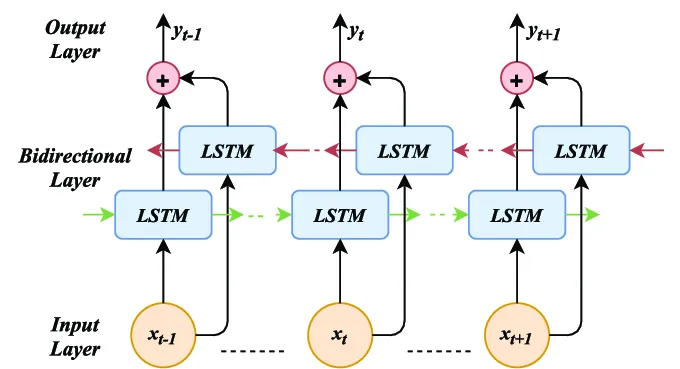



BiLSTM is just the combination of BiRNNs and the usual LSTMs.It works just like the BiRNNs just the hidden layers consists LSTM cells and the output is concatenated as usual just that the output of the Bi-LSTM layer can be used for various purposes depending on the specific task. For example, in text classification, the output may be passed through a fully connected layer followed by a softmax activation to obtain class probabilities(gives the word is most likely to appear). In sequence labeling tasks like named entity recognition, the output may be directly used to predict the label for each input token for eg if the word is an organization or a location,etc.

Resources:https://www.geeksforgeeks.org/bidirectional-recurrent-neural-network/,
https://medium.com/@anishnama20/understanding-bidirectional-lstm-for-sequential-data-processing-b83d6283befc



# Implementation:

Sentiment analysis using the imdb dataset

In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Bidirectional,LSTM,Dense,Dropout

In [3]:
imdb.load_data(num_words=10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


((array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
         list([1, 194, 1153, 194, 8255, 78, 

In [4]:
(X_train,y_train),(X_test,y_test)=imdb.load_data(num_words=10000)

In [5]:
print(X_train.shape,X_test.shape)


(25000,) (25000,)


In [6]:
#truncating the sentences to a length of 100
maxlen=100
num_words=10000

X_train=pad_sequences(X_train,maxlen=maxlen,padding='post',truncating='post')
X_test=pad_sequences(X_test,maxlen=maxlen,padding='post',truncating='post')

embd_dim=32



In [7]:

model=Sequential([Embedding(input_dim=num_words,output_dim=embd_dim,input_length=maxlen),
                  LSTM(150),
                  Dense(1,activation='sigmoid')])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [8]:
from keras.optimizers import Adam
model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])


In [9]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 133s 165ms/step - accuracy: 0.5511 - loss: 0.2471
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 140s 163ms/step - accuracy: 0.6518 - loss: 0.2208
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 152s 195ms/step - accuracy: 0.7649 - loss: 0.1652
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 179s 166ms/step - accuracy: 0.7684 - loss: 0.1612
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 170ms/step - accuracy: 0.8705 - loss: 0.0969
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 135s 162ms/step - accuracy: 0.9060 - loss: 0.0750
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 145s 167ms/step - accuracy: 0.9218 - loss: 0.0644
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 148s 175ms/step - accuracy: 0.9370 - loss: 0.0534
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 146s 180ms/step - accuracy: 0.9472 - loss: 0.0460
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 139s 176ms/step - accuracy: 0.9576 - loss: 0.0373


In [10]:
print(model.evaluate(X_test,y_test))

782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step - accuracy: 0.7905 - loss: 0.1723
[0.17154212296009064, 0.7922800183296204]


In [11]:
model2=Sequential([Embedding(input_dim=num_words,output_dim=embd_dim,input_length=maxlen),
                  Bidirectional(LSTM(150)),
                  Dense(1,activation='sigmoid')])



In [12]:

model2.compile(optimizer=Adam(learning_rate=0.006),loss='mse',metrics=['accuracy'])

In [19]:
model2.fit(X_train,y_train)

782/782 ━━━━━━━━━━━━━━━━━━━━ 250s 318ms/step - accuracy: 0.9833 - loss: 0.0152


In [18]:
model2.evaluate(X_test,y_test)

782/782 ━━━━━━━━━━━━━━━━━━━━ 80s 102ms/step - accuracy: 0.7857 - loss: 0.1893


[0.18660131096839905, 0.7877200245857239]